# Preprocessing script for Multi-attribute Decision Making study
## Authored by Azadeh HajiHosseini & Matthew D. Bachman
### Last updated June 15 2025

Instructions:
- This script is used to clean individual subject's data. Most of the steps are automated and require no input.
- The exception to these rules are the following:
    - Inputting the subject ID
    - Manually selecting the bad channels.
    - Checking the ICA output to determine which components are artifacts.
    - Inputting the ICA components to exclude.
    
Importantly, you may need to change the "savefolder" to ensure that your analysis scripts can find the final preprocessed data.

#### Import different modules

In [24]:
# Initial clean up of already loaded modules
%reload_ext autoreload
%autoreload 2

# Import custom auxilary modules
%run EEG_auxiliary_module_sptm_wICA.ipynb

# Import modules from other sources.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import os.path as op
import mne #MNE is the EEG processing module
from mne.viz import plot_evoked_topo
from IPython.core.debugger import set_trace
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 40em; }</style>"))
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ['PYTHONWARNINGS']='ignore'

#### Load study file and information.
#### **Change "savefolder" here**

In [321]:
# General file path
plt.close('All')
study        = 'MADeEEG1' # Study Name
studyPathInd = os.getcwd().find(study) # Find relevant directory
dataPath     = op.join(os.getcwd()[:studyPathInd+len(study)],'EEG data')

# Specify file name (needs to by input each time)
subj = input('Enter Subject Number: ')
file_name='Subj_'+subj+'.bdf'
fname = op.join(dataPath,file_name)
savefolder = 'Results\\'+subj
if os.path.isdir(savefolder) == False:
    os.makedirs(savefolder)

Enter Subject Number: 195


#### Define epoch parameters

In [58]:
#Start and end of each epoch, in seconds
segment_times = (-.2,3) # -200 to 3000 ms around each stimulus. The large window is taken to also envelope the dot period.

#Baseline period for each epoch
baseline = (-.2,0) #-200 to 0ms.     

# Define stimulus-locked triggers
trigs = list(range(101, 126))
event_keys=['Face1/Color1','Face1/Color2','Face1/Color3','Face1/Color4','Face1/Color5',
           'Face2/Color1','Face2/Color2','Face2/Color3','Face2/Color4','Face2/Color5',
           'Face3/Color1','Face3/Color2','Face3/Color3','Face3/Color4','Face3/Color5',
           'Face4/Color1','Face4/Color2','Face4/Color3','Face4/Color4','Face4/Color5',
           'Face5/Color1','Face5/Color2','Face5/Color3','Face5/Color4','Face5/Color5']
event_ids_stim  = {event_keys[i]:trigs[i] for i in range(len(trigs))}

#### Load data, filter, and find bad channels

In [322]:
%matplotlib qt

# Define the EEG aray as a standard 10-20
montage = mne.channels.make_standard_montage("standard_1020") #MB

# Define filter as between .05 to 45.
filt = (.05,40)

#Read and filter the raw bdf file
raw = mne.io.read_raw_bdf(fname,eog=['VEOG'],preload=True).filter(filt[0], filt[1], method='iir')
raw.set_eeg_reference(['M1','M2'])  # Rereference right while loading it. Key step for recovering SNR, as reccomended by BioSemi.


#drop extra channels
raw.drop_channels(['EXG4','EXG5','EXG6','EXG7','EXG8','M1','M2'])

# Set the montage
raw.set_montage(montage) 

# Plot the raw data in a new window, and manually select the bad channels.
fig = raw.plot(n_channels=66)
print(raw.info['bads'])

Extracting EDF parameters from E:\Bachman\MADeEEG1\EEG data\Subj_195.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1694207  =      0.000 ...  3308.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.05, 40.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
[]
Channels marked as bad:
['P3']


#### Find epochs, correct to baseline

In [323]:
# Interpolate the bad electrodes. 
# Azadeh note: it may create issues with SVM or not if reset_bads not set to False, you lose the info on which channels you marked as bad
## and interpolated
raw_interp = raw.interpolate_bads(reset_bads=False) 
raw_interp.plot(n_channels = 66)

#read events in the full experiment
events = mne.find_events(raw_interp, initial_event=True, consecutive=True, shortest_event=1)

#epoch full experiment
epochs_stim  = mne.Epochs(raw_interp, events, event_ids_stim, segment_times[0], segment_times[1],baseline=baseline, preload=True,detrend=1)

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
3608 events found on stim channel Status
Event IDs: [  100   101   102   103   104   105   106   107   108   109   110   111
   112   113   114   115   116   117   118   119   120   121   122   123
   124   125   198   200   201   202   203   204   205   206   207   208
   209   210 65536 65734 65791]
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 600 events and 1639 original time points ...
0 bad epochs dropped
Channels marked as bad:
['P3']


#### ICA eye-blink removal Stim

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 17.0s.
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


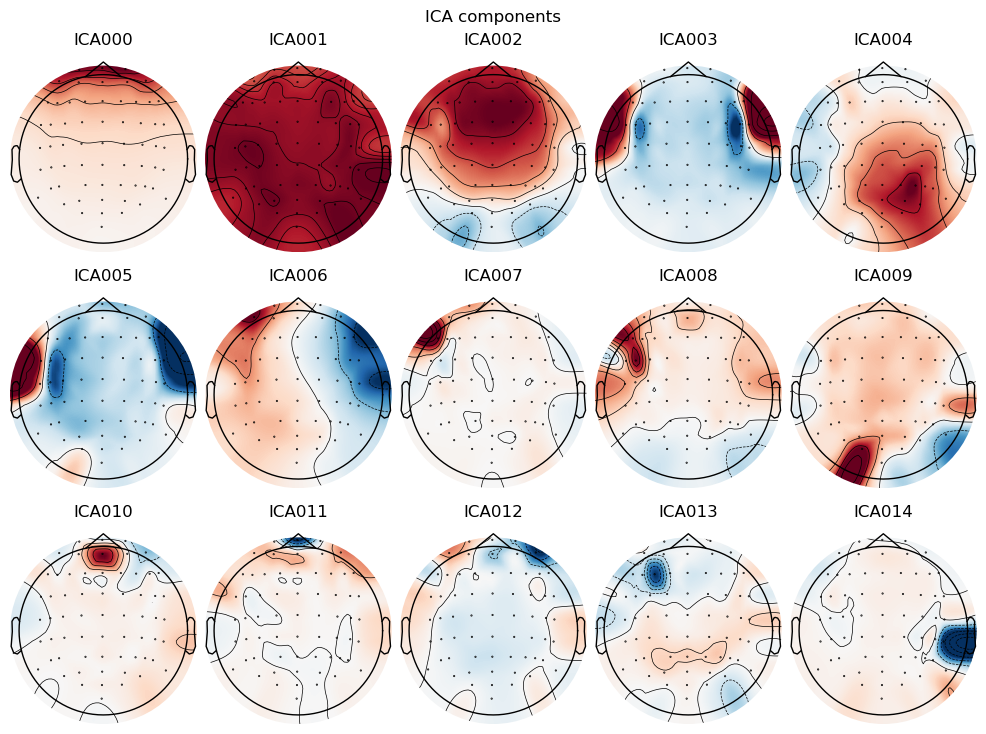

In [324]:
%matplotlib qt

# ICA before average referencing, because we need VEOG for ICA but we don't want that to be part of the average reference 
from mne.preprocessing import ICA, create_eog_epochs, corrmap

# Look through the ICA plots to pick any eyeblink artifacts. Insert their numbers in the cell below this one.
eye_picks_stim = mne.pick_types(epochs_stim.info,eog=True,eeg=False, stim = False)
ica_stim = ICA(n_components=15, random_state=97)
ica_stim.fit(epochs_stim)
fig = ica_stim.plot_sources(epochs_stim)
ica_stim.plot_components()

#### find blink ica components and reconstruct Stim

In [318]:
# INPUT WHICH COMPONENTS TO EXCLUDE
ica_stim.exclude = [0]
print ('the eye component is identified as IC:'+str(ica_stim.exclude))

## Bring up several plots to show what the data looks like without the excluded component(s)
ica_stim.plot_overlay(raw_interp, exclude=ica_stim.exclude, picks='eeg')

# barplot of ICA component "EOG match" scores
#ca_stim.plot_scores(eog_scores)

# # plot diagnostics
ica_stim.plot_properties(epochs_stim, picks=ica_stim.exclude)

# plot ICs applied to epoched data, with EOG matches highlighted
ica_stim.plot_sources(epochs_stim)

#reconstruct epoched data removing eye artifacts
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_epochs_stim = epochs_stim.copy()
ica_stim.apply(reconst_epochs_stim)
scalings = dict(eeg=100e-6)
epochs_stim.plot(n_channels=66,scalings=scalings)
reconst_epochs_stim.plot(n_channels=66,scalings=scalings)
reconst_epochs_stim.drop_channels(['Status','VEOG'])


the eye component is identified as IC:[0]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components


Number of events,600
Events,Face1/Color1: 24Face1/Color2: 24Face1/Color3: 24Face1/Color4: 24Face1/Color5: 24Face2/Color1: 24Face2/Color2: 24Face2/Color3: 24Face2/Color4: 24Face2/Color5: 24Face3/Color1: 24Face3/Color2: 24Face3/Color3: 24Face3/Color4: 24Face3/Color5: 24Face4/Color1: 24Face4/Color2: 24Face4/Color3: 24Face4/Color4: 24Face4/Color5: 24Face5/Color1: 24Face5/Color2: 24Face5/Color3: 24Face5/Color4: 24Face5/Color5: 24
Time range,-0.199 – 3.000 s
Baseline,-0.200 – 0.000 s


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['F2', 'P3', 'P6', 'F3', 'P8', 'PO8']
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['F2', 'P3', 'P6', 'F3', 'P8', 'PO8']


#### Reference to average and save

In [319]:
reconst_epochs_stim.set_eeg_reference('average') 
reconst_epochs_stim.plot(n_channels=66,scalings = scalings)
reconst_epochs_stim.apply_baseline(baseline=baseline)

savefile = op.join(savefolder,'stimDataMicVolts-epo_v2_reref.fif')
reconst_epochs_stim.save(savefile,overwrite=True)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Applying baseline correction (mode: mean)
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['F2', 'P3', 'P6', 'F3', 'P8', 'PO8']


#### drop extra channels, re-reference, zscore, threshold, plot results Stim

In [320]:
# Redo previous steps. Not sure if this is needed or if the original file is overwritten.
%matplotlib qt
reconst_epochs_stim = epochs_stim.copy()
ica_stim.apply(reconst_epochs_stim)
reconst_epochs_stim.drop_channels(['Status','VEOG'])

# # re-ref to averaged channels
reconst_epochs_stim.set_eeg_reference('average') 

#  zscore on channels and time
epochsz_stim = zscore_threshold_epochs(reconst_epochs_stim, 2, 3);
epochsz_stim.apply_baseline(baseline=baseline)
print(epochsz_stim.baseline)
print(epochsz_stim.info)
reconst_epochs_stim.plot(n_channels=66,scalings = scalings)
epochsz_stim.plot(n_channels=66,scalings = dict(eeg=20))

# Save data.
savefile = op.join(savefolder,'stimData-epo_v2_reref.fif')
epochsz_stim.save(savefile,overwrite=True)

Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(600, 64, 1639)
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Applying baseline correction (mode: mean)
(-0.2, 0.0)
<Info | 11 non-empty values
 bads: 6 items (F2, P3, P6, F3, P8, PO8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2023-08-05 12:01:30 UTC
 nchan: 64
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['F2', 'P3', 'P6', 'F3', 'P8', 'PO8']
Dropped 0 epochs: 
The following